In [1]:
import numpy as np # linear algebra
import pandas as pd

In [2]:
!pip install sentence-transformers

In [5]:
! nvidia-smi

Sun Jun 26 08:07:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 462.80       Driver Version: 462.80       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce MX330      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P8    N/A /  N/A |     64MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
!pip install textblob

In [7]:
import pandas as pd
import time
from tqdm import tqdm
import seaborn as sns
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')

In [8]:
data = pd.read_csv('preprocess_dataset.csv',memory_map=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2652 entries, 0 to 2651
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2652 non-null   int64 
 1   heading     2652 non-null   object
 2   text        2645 non-null   object
 3   url         2652 non-null   object
dtypes: int64(1), object(3)
memory usage: 83.0+ KB


In [9]:
data.head()

,Unnamed: 0,heading,text,url
0,0,Reasons to Buy Bajaj Allianz Travel Insurance,Whether you are planning a solo backpacking tr...,https://www.bajajfinservmarkets.in/insurance/t...
1,1,Why Travel Insurance is a Must-Have?,Why Travel Insurance is a Must-Have?What is th...,https://www.bajajfinservmarkets.in/insurance/t...
2,2,Why Choose Bajaj Allianz Travel Insurance?,Why Choose Bajaj Allianz Travel Insurance?You ...,https://www.bajajfinservmarkets.in/insurance/t...
3,3,Types of Travel Insurance Plans Available on F...,Types of Travel Insurance Plans Available on F...,https://www.bajajfinservmarkets.in/insurance/t...
4,4,Top Destination Covered Under Travel Insurance...,Top Destination Covered Under Travel Insurance...,https://www.bajajfinservmarkets.in/insurance/t...


In [10]:
import gc #garbage collector
df = data[['heading','text','url']]
del data
gc.collect()

37

In [11]:
df.dropna(inplace=True)
df.drop_duplicates(subset=['heading'],inplace=True)

C:\Users\KIIT\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


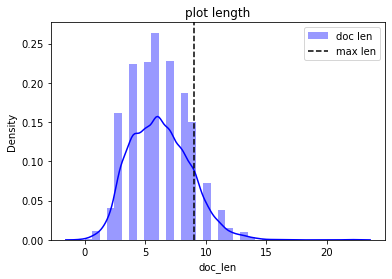

In [12]:
df['doc_len'] = df['heading'].apply(lambda words: len(words.split()))
max_seq_len = np.round(df['doc_len'].mean() + df['doc_len'].std()).astype(int)
sns.distplot(df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('plot length'); plt.legend()
plt.show()

In [14]:
!pip install faiss-cpu 

In [18]:
import faiss
encoded_data = model.encode(df.heading.tolist())
encoded_data = np.asarray(encoded_data.astype('float32'))
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index1=faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(0, len(df)).astype(np.int64)))
faiss.write_index(index, 'heading.index')
faiss.write_index(index1,'url.index')

AttributeError: 'range' object has no attribute 'astype'

In [ ]:
df.head()

In [ ]:
def fetch_info(dataframe_idx):
    info = df.iloc[dataframe_idx]
    meta_dict = {}
    meta_dict['heading'] = info['heading']
    meta_dict['url']=info['url']
    return meta_dict
    
def search(query, top_k, index, model):
    t=time.time()
    query_vector = model.encode([query])
    top_k = index.search(query_vector, top_k)
    print('>>>> Results in Total Time: {}'.format(time.time()-t))
    top_k_ids = top_k[1].tolist()[0]
    top_k_ids = list(np.unique(top_k_ids))
    results =  [fetch_info(idx) for idx in top_k_ids]
    return results

In [ ]:
from pprint import pprint
from textblob import Word
query="health"
word = Word(query)
result = word.correct()


results=search(result, top_k=5, index=index, model=model)

for r in results:
    print(r)